# DEEP  LEARNING ASSESSED EXERCISE 2019
​
​
Radhika Agrawal
 
 

## 1. INTRODUCTION

The aim of this excercise is to do build a classifier and test it on a collection of images for a new task using Keras.
Simple to deep convolutional neural networks will be employed to classify  images directly into 5 classes of food dataset.
### 1.1 OVERVIEW
In order to classify several food dishes into its respective categories, following strategy is being used:

**Step 1**: Build a simple baseline model and train the food dataset on the model.
             Analyse its accuracy and loss using graphs.
             
**Step 2:**  Build a bit more deeper model from scratch and train the food dataset on the model.
             Analyse its accuracy and loss using graphs.
             The aim is to check if there is a change in training accuracy after adding convolutional and maxpooling layers to the model.

**Step 3:** Preprocess the data by augmenting it in several ways.
The aim is to analyse the effect of data augmentation on the accuracy of the same complex model. Also add drop out layers to reduce overfitting.
Again, analyse the accuracy and loss calculated while trying to classify the data using graphs and confusion matrix.

**Step 4:** Tune Hyper parameters in the previous model from step 3.

**Step 5:** Fine tune a pre-trained model, VGG16 and pass the same pre processed dataset.
The objective is to solve a new problem using transfer Learning. Transfer learning is the reuse of a pre-trained model, in this case VGG16. It is currently very popular in the field of Deep Learning because it enables you to train Deep Neural Networks with comparatively little data.[1]
It is expected that the accuracy will increase and the loss will decrease as the model is already trained.
Next step is to analyse the pre_trained model through visualizations.

[1] https://towardsdatascience.com/transfer-learning-946518f95666

## 2. **ANALYSIS OF DATA**
Fthe Food dataset is downloaded from Food-475 Database [2] which consists of 250 classes.
I have chosen 5 classes from the available 250 classes.

Each of thes classes are labelled with 5 food dishes and contain approximately 110 images.

Note: I have modified the dataset by removing the images with low resolution and adding a few better quality images.


[2] http://www.ivl.disco.unimib.it/activities/food475db/





### 2.1 INITIAL SETUP

In [0]:
#the data can be downloaded from the drop box


!wget https://www.dropbox.com/s/pc77x1d9dzvnf20/FoodData.zip?dl=0

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/FoodData"

In [0]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import matplotlib.image as mpimg
import time
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Flatten, Conv2D
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [0]:
#@title Load the Food data set and split into test & train sets [RUN ME]
Food_DIR = './FoodData'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


if not os.path.exists('./Foodd'):
    os.mkdir('./Foodd')


image_dir = Food_DIR
from sklearn.model_selection import train_test_split

# Read all food images (.jpg) from a folder
# The function returns both the path of the food image and the corresponding label
# which is defined by the name of the foler in which the image is
def read_images_from_dir(base_dir, folder):
    path_folder = os.path.join(image_dir, folder)
    files_directory = os.listdir(path_folder)
    
    labels = []
    images = []
    for file in files_directory:
        if file.endswith('.jpg'):
            labels.append(folder)
            images.append(os.path.join(path_folder, file))
    return labels, images

def read_images(base_dir):
    labels = []
    images = []
    folders = os.listdir(image_dir)
    for folder in folders:
        labels_folder, images_folder = read_images_from_dir(base_dir, folder)
        labels.extend(labels_folder)
        images.extend(images_folder)
    return labels, images

labels, images = read_images(image_dir)


# Split the data into test and training sets
images_train, images_test, labels_train,labels_test = train_test_split(images, labels, test_size=0.3, random_state=8, stratify=labels)
images_train, images_validation, labels_train,labels_validation = train_test_split(images_train, labels_train, test_size=0.3, random_state=8, stratify=labels_train)


# Create folders for test and training that can be passed to Keras Generators
train_folder = './Foodd/output/train'
test_folder  = './Foodd/output/test'
validation_folder = './Foodd/output/valid'
output_folder = './Foodd/output'

def create_output_folders():
    if not os.path.exists(output_folder):
        print('Creating output directories')
        os.mkdir(output_folder)
        
        if not os.path.exists(train_folder):
            os.mkdir(train_folder)
            for label in set(labels):
                os.mkdir(train_folder + '/' + label)
                
        if not os.path.exists(test_folder):
            os.mkdir(test_folder)
            for label in set(labels):
                os.mkdir(test_folder + '/' + label)
                
        if not os.path.exists(validation_folder):
            os.mkdir(validation_folder)
            for label in set(labels):
                os.mkdir(validation_folder + '/' + label)

def copy_files_to_train_and_validation_folders():            
    print('Copy training files to directory')
    for index, value in enumerate(images_train):
        dest = os.path.join(train_folder, labels_train[index])
        shutil.copy(value, dest)

    print('Copy test files to directory')        
    for index, value in enumerate(images_test):
        shutil.copy(value, test_folder + '/' + labels_test[index])
        
    print('Copy validation files to directory')        
    for index, value in enumerate(images_validation):
        shutil.copy(value, validation_folder + '/' + labels_validation[index])
        
create_output_folders()
copy_files_to_train_and_validation_folders()

Creating output directories
Copy training files to directory
Copy test files to directory
Copy validation files to directory


###2.2 Preprocessing:
It is used to rescale the pixel values from [0,255] to [0,1] interval

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 24

It automatically retrieves images and their classes for train, validation and test sets.


In [0]:
#images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=8, stratify=labels)

image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator      = data_generator.flow_from_directory(train_folder, target_size=(image_size, image_size), classes=['omlette','pancakes','pastry','samosa','sandwich']   ,batch_size=24, class_mode='categorical')
validation_generator = data_generator.flow_from_directory(validation_folder, target_size=(image_size, image_size), classes=['omlette','pancakes','pastry','samosa','sandwich']   ,batch_size=24, class_mode='categorical')
test_generator = data_generator.flow_from_directory(test_folder, target_size=(image_size, image_size), batch_size=24,classes=['omlette','pancakes','pastry','samosa','sandwich']  ,shuffle=False , class_mode='categorical')

Found 249 images belonging to 5 classes.
Found 108 images belonging to 5 classes.
Found 154 images belonging to 5 classes.


### 2.3 Analysis of the data type, quality and class distributions.


The motive behind choosing these 5 classes was to see if the model understands the difference between a 'pastry' and a 'sandwich'. It appears easy for human eyes to identify the difference, but for a model to identify this difference is pretty challenging. For most of the images, a pastry has a high chance of getting classified as a sandwich due its layered appearance. The model here should be able to identify the texture of the bread and not get confused with cream of a pastry.

Another challenge the model can face in this 5 class classification problem is while classifying a 'pancake' and an 'omelette'. Given their same appearance, the model is expected to identify them as separate classes based on the colour and texture and density and other parameters.

I have added a totally different class of food dish ('samosa') to see if it gets  as close to 100% accuracy in its classfication as it has less features matching with other classes.

**For example**: It is highly likely, that looking at the bottom two images, the model can classify them in the same class.

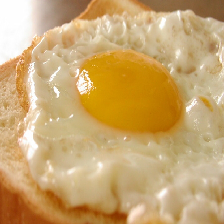

In [0]:
img_path = 'FoodData/omlette/6855.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img

#Class 1 : image of an omelette

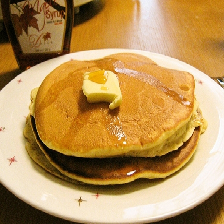

In [0]:
img_path2 = 'FoodData/pancakes/9767.jpg' 
img3 = image.load_img(img_path2, target_size=(224, 224))
img3

#class 2 : image of pancake

**Another example** of differntiation between classes of Pastry and sandwich,
where there are some chances that they can be classified into one class.

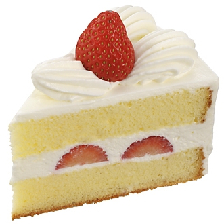

In [0]:
img_path2 = 'FoodData/pastry/18309.jpg' 
img3 = image.load_img(img_path2, target_size=(224, 224))
img3

#class 2 : image of pastry

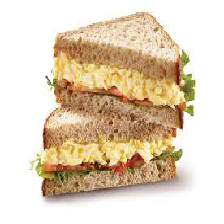

In [0]:
img_path2 = 'FoodData/sandwich/6873.jpg' 
img3 = image.load_img(img_path2, target_size=(224, 224))
img3

#class 2 : image of sandwich

### 2.4  **Visualising the 5 classes with its true labels**

<Figure size 2160x2160 with 0 Axes>

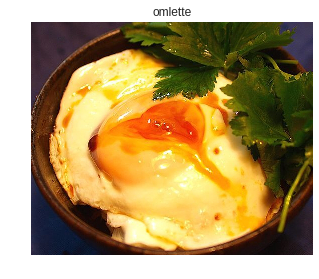

<Figure size 2160x2160 with 0 Axes>

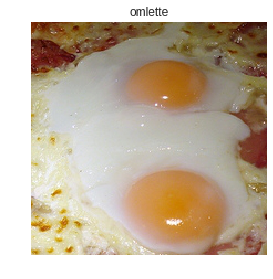

<Figure size 2160x2160 with 0 Axes>

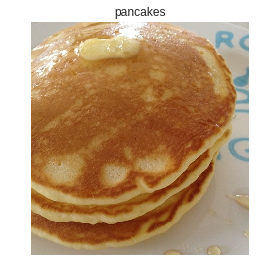

<Figure size 2160x2160 with 0 Axes>

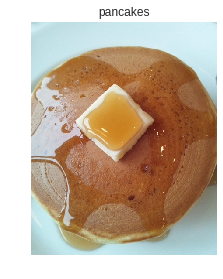

<Figure size 2160x2160 with 0 Axes>

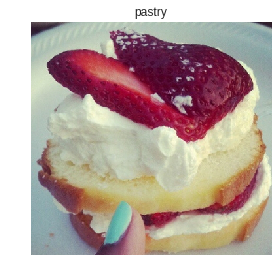

<Figure size 2160x2160 with 0 Axes>

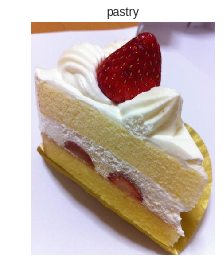

<Figure size 2160x2160 with 0 Axes>

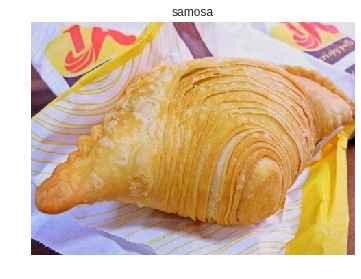

<Figure size 2160x2160 with 0 Axes>

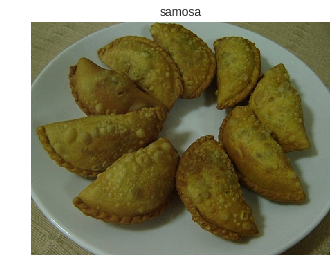

<Figure size 2160x2160 with 0 Axes>

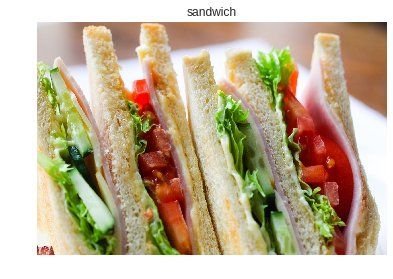

<Figure size 2160x2160 with 0 Axes>

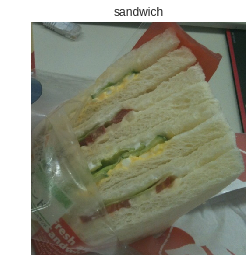

<Figure size 2160x2160 with 0 Axes>

In [0]:
plt.figure(figsize=(30, 30))

nrows = 6
ncols = 2

# attempt to seperate the classes
class1, class2, class3, class4, class5 = [], [], [], [], []
classnames = ['omlette','pancakes','pastry','samosa','sandwich'] 
for label, image_arr in zip(labels, images):
  if label == 'omlette':
    class1.append(image_arr)
  elif label == 'pancakes':
    class2.append(image_arr)
  elif label == 'pastry':
    class3.append(image_arr)
  elif label == 'samosa':
    class4.append(image_arr)
  elif label == 'sandwich':
    class5.append(image_arr)
  

for classname, classarr in zip(classnames, [class1,class2,class3,class4,class5]):
  for i, image_arr in enumerate(classarr[:2]):
    plt.figure(figsize=(30, 30))
  #  print(i+1, j, j*ncols + i+1, ' meh ', ncols, nrows)
    plt.subplot(nrows, ncols, i+1)
    
    plt.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(image_arr)
    plt.title(classname)
    plt.imshow(img)
    plt.figure(figsize=(30, 30))
  plt.show()

## 3. BASELINE MODEL




### 3.1 Small Sequential Conv Net Model architecture definition:

A simple stack of  dense input layer, 3 convolution layers with a ReLU activation and a dense output layer.

The output layer has 5 neurons for 5 classes

In [0]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Flatten, Conv2D
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model



model=Sequential([
    Dense(16,input_shape=(224,224,3),activation='relu'),
    Conv2D(32,kernel_size=(3,3),activation='relu'),
    Conv2D(64,kernel_size=(3,3),activation='relu'),
    Conv2D(64,kernel_size=(3,3),activation='relu'),
    Flatten(),
    Dense(5,activation='softmax'),
])

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 224, 224, 16)      64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 222, 222, 32)      4640      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 220, 220, 64)      18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 218, 218, 64)      36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 3041536)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 15207685  
Total params: 15,267,813
Trainable params: 15,267,813
Non-trainable params: 0
________________________________________________________________

### 3.2 Training of baseline model

In [0]:


history=model.fit_generator(train_generator,
                            steps_per_epoch=11,
                            epochs=10,
                            validation_data=validation_generator,
                            validation_steps=5)

Epoch 1/10
11/11 [==============================] - 11s 964ms/step - loss: 11.5664 - acc: 0.2570 - val_loss: 12.5363 - val_acc: 0.2222
Epoch 2/10
11/11 [==============================] - 4s 377ms/step - loss: 12.0953 - acc: 0.2496 - val_loss: 12.3871 - val_acc: 0.2315
Epoch 3/10
11/11 [==============================] - 4s 377ms/step - loss: 12.2819 - acc: 0.2380 - val_loss: 12.9840 - val_acc: 0.1944
Epoch 4/10
11/11 [==============================] - 4s 378ms/step - loss: 12.2819 - acc: 0.2380 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 5/10
11/11 [==============================] - 4s 378ms/step - loss: 12.1886 - acc: 0.2438 - val_loss: 12.9840 - val_acc: 0.1944
Epoch 6/10
11/11 [==============================] - 4s 380ms/step - loss: 11.9088 - acc: 0.2612 - val_loss: 12.3871 - val_acc: 0.2315
Epoch 7/10
11/11 [==============================] - 4s 377ms/step - loss: 12.0953 - acc: 0.2496 - val_loss: 12.3871 - val_acc: 0.2315
Epoch 8/10
11/11 [==============================] - 4s 377ms/

### 3.3 Plotting graphs to analyse the loss and accuracy

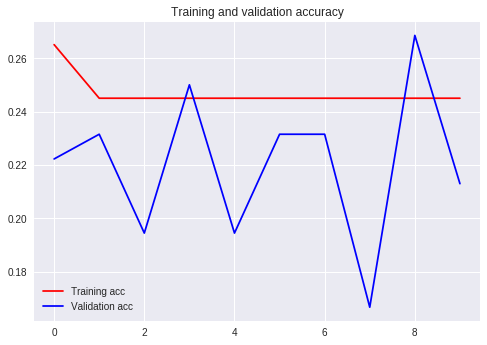

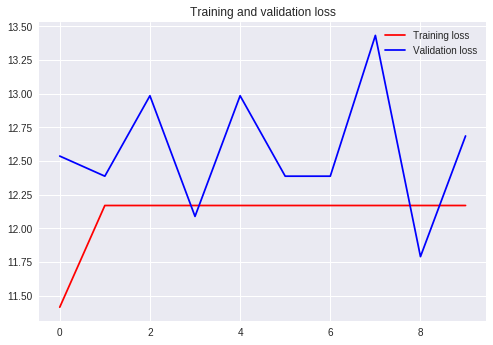

In [0]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 3.4 Results from baseline model:
Clearly, the simple model did not do well while  training the data.

The accuracy is very poor as expected for such a complex task. 

**The validation accuracy is just in the range of 20-21%**

We can enhance the accuracy and minimize the loss by augmenting the data. This will also prevent the model from overfitting.

There is also a need to add more building blocks to the CNN. Adding pooling layer will operate on each feature map independently and hence enhance the process of fitting and prediction.


## 4. Building a deeper model from scratch.



### 4.1** Architecture:**
A simple stack of 4 convolution layers with a ReLU activation and followed by max-pooling layers.

This is followed by output dense laye with 5 neurons. Generally, softmax activation is used instead of sigmoid with the cross-entropy loss because softmax activation distributes the probability throughout each output node.
Since, this is a  multi-class classification I have used sofmax with  categorical cross-entropy.

In [0]:
from keras import layers
from keras import models

mmodel = models.Sequential()
mmodel.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224,224, 3)))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Conv2D(128, (3, 3), activation='relu'))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Conv2D(128, (3, 3), activation='relu'))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Flatten())

mmodel.add(layers.Dense(512, activation='relu'))
mmodel.add(layers.Dense(5, activation='softmax'))

mmodel.summary()

mmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 128)       147584    
__________

### 4.2 Train the model

In [0]:

history1=mmodel.fit_generator(train_generator,
                            steps_per_epoch=11,
                            epochs=30,
                            validation_data=validation_generator,
                            validation_steps=5)

Epoch 1/30
11/11 [==============================] - 2s 176ms/step - loss: 1.5083 - acc: 0.2572 - val_loss: 1.6094 - val_acc: 0.2407
Epoch 2/30
11/11 [==============================] - 2s 150ms/step - loss: 1.5940 - acc: 0.2400 - val_loss: 1.6094 - val_acc: 0.2407
Epoch 3/30
11/11 [==============================] - 2s 179ms/step - loss: 1.5940 - acc: 0.2171 - val_loss: 1.6094 - val_acc: 0.2315
Epoch 4/30
11/11 [==============================] - 2s 176ms/step - loss: 1.5940 - acc: 0.2494 - val_loss: 1.6094 - val_acc: 0.2407
Epoch 5/30
11/11 [==============================] - 2s 177ms/step - loss: 1.5940 - acc: 0.2420 - val_loss: 1.6094 - val_acc: 0.2222
Epoch 6/30
11/11 [==============================] - 2s 175ms/step - loss: 1.5940 - acc: 0.2439 - val_loss: 1.6094 - val_acc: 0.2315
Epoch 7/30
11/11 [==============================] - 2s 178ms/step - loss: 1.5940 - acc: 0.2152 - val_loss: 1.6094 - val_acc: 0.2500
Epoch 8/30
11/11 [==============================] - 2s 174ms/step - loss: 1.

### 4.3 Checking accuracy and loss by plotting graphs

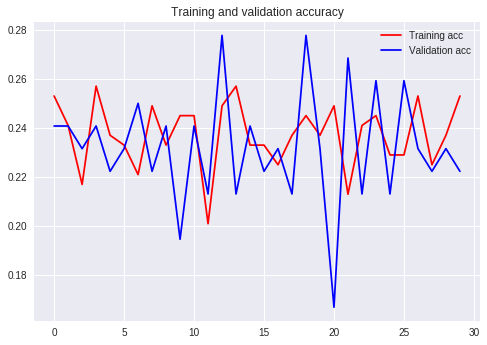

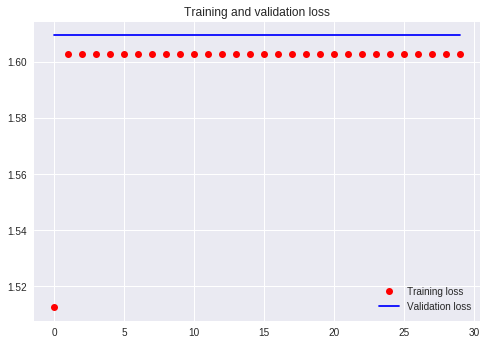

In [0]:

import matplotlib.pyplot as plt

acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 4.4 Results from deeper Convolutional Network

**This complex model did increase the validation accuracy by 5% and brought it to 23%.
But the accuracy is still very poor. **

We can also notice that the data is overfitting, ie it is performing good while training but is not doing as good a fit with the validation set.

Overfitting is happening because this model is exposed to too few examples to learn patterns and is not able to generalize to new data, as the model at some point might have started using irrelevant features for making predictions. 


## 5. Techniques to reduce overfitting.
1. Data Augmentation
2. Adding Dropout layers




### 5.1 Data Augmentation

The easiest and most common method to reduce overfitting on image data is to artificially enlarge the dataset using label-preserving transformations.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows us to:

Configure random transformations and normalization operations to be done on the image data during training instantiate generators of augmented image batches (and their labels) via .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

I have applied the following 5 tranformations  [4]: 

1. Rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
2. horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
3. rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
4. shear_range is for randomly applying shearing transformations
5. zoom_range is for randomly zooming inside pictures



[4] https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


In [0]:
image_size = 224
train_datagen_augmented = ImageDataGenerator(
        rescale=1./255,        # normalize pixel values to [0,1]
        shear_range=0.2,       # randomly applies shearing transformation
        zoom_range=0.2,        # randomly applies shearing transformation
        horizontal_flip=True,  # randomly flip the images
        rotation_range=10)     #rotates it 10 radians

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


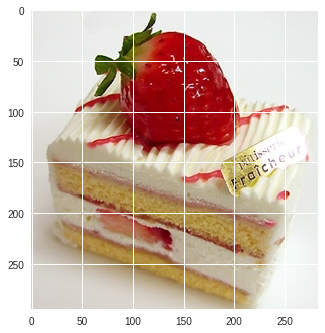

In [0]:
image_path='FoodData/pastry/18341.jpg'
from scipy import ndimage
image=np.expand_dims(ndimage.imread(image_path),0)
plt.imshow(image[0])

#original image.

In [0]:
#generate batches of augmented images from this image
aug_iter=train_datagen_augmented.flow(image)

#get 5 samples of augmented image
aug_images = [next(aug_iter)[0] for i in range(5)]


### **5.2 Plotting images after augmentation**

Data and labels of one batch of 10:



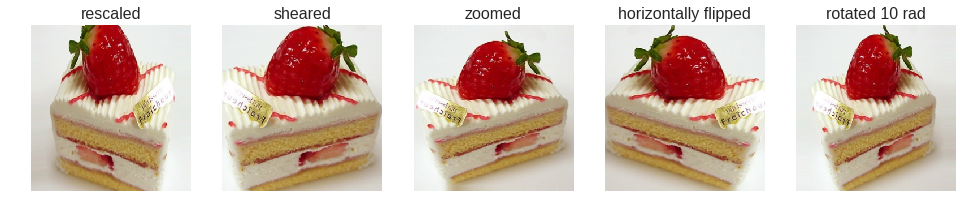

In [0]:
#plot augmented images

def plot_images_and_labels(ims, figsize=(20,6), rows=1, interp=False, titles=None):
  
  f = plt.figure(figsize=figsize)
  cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
  for i in range(len(ims)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)                                   
      #sp.set_title(reverse[titles[i][1]], fontsize=16)            
    plt.imshow(ims[i], interpolation=None if interp else 'none')

print("Data and labels of one batch of 10:\n")
plot_images_and_labels(aug_images,figsize=(20,6), rows=1, interp=False, titles=['rescaled','sheared','zoomed','horizontally flipped','rotated 10 rad'])

In [0]:



train_generator_augmented = train_datagen_augmented.flow_from_directory(train_folder, target_size=(image_size, image_size), batch_size=24, class_mode='categorical')


Found 249 images belonging to 5 classes.


### 5.2 Same model Architecture with Drop out and augmented data:

Data augmentation is one way to fight overfitting, but it isn't enough since the augmented samples are still highly correlated.

In this case I will use a very small convnet with few layers and few filters per layer, alongside data augmentation and dropout.

Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).


In [0]:

from keras import layers
from keras import models


mmodel = models.Sequential()
mmodel.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224,224, 3)))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Conv2D(32, (3, 3), activation='relu'))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Flatten())

mmodel.add(layers.Dense(64, activation='relu'))
mmodel.add(layers.Dropout(0.5))
mmodel.add(layers.Dense(5, activation='softmax'))

mmodel.summary()

mmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 24, 64)        36928     
__________

### 5.3 Training the complex model with the augmented images

In [0]:
history2=mmodel.fit_generator(
        train_generator_augmented,
        steps_per_epoch=11,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=5)   

Epoch 1/20
11/11 [==============================] - 4s 401ms/step - loss: 1.5937 - acc: 0.2516 - val_loss: 12.9840 - val_acc: 0.1944
Epoch 2/20
11/11 [==============================] - 4s 383ms/step - loss: 1.5771 - acc: 0.2650 - val_loss: 12.2959 - val_acc: 0.2315
Epoch 3/20
11/11 [==============================] - 4s 391ms/step - loss: 1.5578 - acc: 0.2819 - val_loss: 11.8304 - val_acc: 0.2593
Epoch 4/20
11/11 [==============================] - 4s 386ms/step - loss: 1.4998 - acc: 0.3160 - val_loss: 12.0244 - val_acc: 0.2407
Epoch 5/20
11/11 [==============================] - 4s 387ms/step - loss: 1.4967 - acc: 0.3408 - val_loss: 11.8908 - val_acc: 0.2407
Epoch 6/20
11/11 [==============================] - 4s 384ms/step - loss: 1.4266 - acc: 0.3846 - val_loss: 11.2299 - val_acc: 0.2685
Epoch 7/20
11/11 [==============================] - 4s 387ms/step - loss: 1.3870 - acc: 0.4326 - val_loss: 11.4722 - val_acc: 0.2685
Epoch 8/20
11/11 [==============================] - 4s 388ms/step - l

### 5.4 Analysing the results by plotting graphs

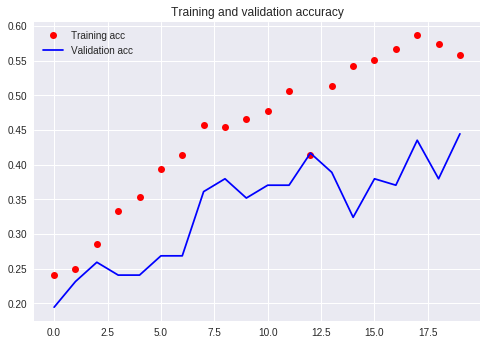

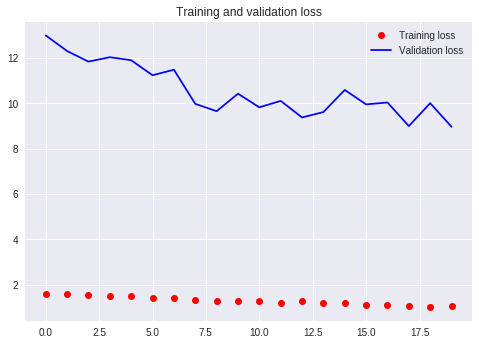

In [0]:

import matplotlib.pyplot as plt

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 5.6 Plotting confusion Matrix 

source of the code from sklearn.[2]

[2] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [0]:
#Confusion matrix
#source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    
    thresh =cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

[0 0 2 2 2 2 0 0 4 4 0 0 0 0 0 0 2 2 2 2 0 4 2 4 4 0 4 0 2 4 4 0 4 4 4 4 4
 4 2 0 0 3 0 4 0 0 0 4 4 4 4 0 4 0 0 0 0 2 3 0 0 2 2 4 2 0 0 2 0 4 0 2 0 4
 2 2 0 0 4 4 4 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 4 0 0 4 0 4 4 2 0 2 0 0 2 3 0 4 0 2 2 2 4 2 0 4 4 0 0 2 0 4 4 0
 2 2 2 2 0 2]
Confusion matrix, without normalization
[[14  0 10  0 13]
 [14  0  5  2  8]
 [17  0  4  0  8]
 [24  0  1  0  5]
 [10  0 12  1  6]]


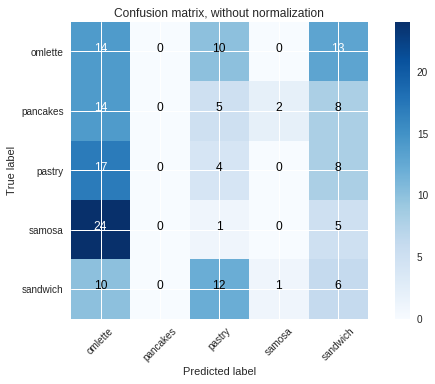

In [0]:

classes=['omlette','pancakes','pastry','samosa','sandwich']   
labels_test=test_generator.classes
predictions2= mmodel.predict_generator(test_generator,steps=7,verbose=0)
print(predictions2.argmax(axis=1))
cm2=confusion_matrix(labels_test,predictions2.argmax(axis=1))

# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm2, classes,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cm, classes=labels_test, normalize=True,
 #                     title='Normalized confusion matrix')

plt.show()







### 5.7 Results from passing augmentated data to the fairly deeper model.
Even the Deeper network model couldn't perform well while fitting and obviously wouldn't be able to perform well while prediction.
Because the model is small and uses aggressive dropout, it does not seem to be overfitting too much by that point.


There is need for using the bottleneck features of a pre-trained network that can extract the features and comprehend complex patterns from the images to be able to classify them more accurately. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy.

### 5.8 Tuning hyper parameters

Tuning Parameters:

1.Tuning the optimizer type to Adam

2.Tuning learing rate to 1e-3

3.Changing activation function from relu to elu

In [0]:
from keras import layers
from keras import models


mmodel = models.Sequential()
mmodel.add(layers.Conv2D(32, (3, 3), activation='elu',
                        input_shape=(224,224, 3)))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Conv2D(32, (3, 3), activation='elu'))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Conv2D(64, (3, 3), activation='elu'))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Conv2D(64, (3, 3), activation='elu'))
mmodel.add(layers.MaxPooling2D((2, 2)))

mmodel.add(layers.Flatten())

mmodel.add(layers.Dense(64, activation='elu'))
mmodel.add(layers.Dropout(0.5))
mmodel.add(layers.Dense(5, activation='softmax'))

mmodel.summary()

mmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc'])

history2=mmodel.fit_generator(
        train_generator_augmented,
        steps_per_epoch=11,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=5)   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 24, 24, 64)        36928     
__________

###5.9 Plotting graphs for the hyper parameterized model.

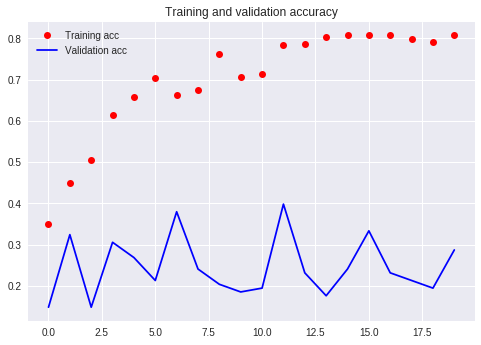

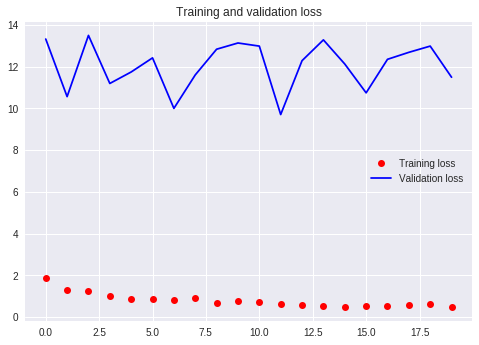

In [0]:

import matplotlib.pyplot as plt

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 5.10 Results after changing Hyper parameters.

Clearly, the model with Activation = Relu , learning rate=1 e-4 and optimizer= RMSprop performed better with validation accuracy as 44% 

than model with Activation = elu , learning rate=1 e-3 and optimizer= Adam with validation accuracy as approximately 33%

There is a difference of nearly 11% in the validation accuracy.

## 6. Using a Pre-trained model - VGG16

VGG16 architecture, pre-trained on the ImageNet dataset --a model previously featured on this blog. Because the ImageNet dataset contains several "cat" classes  and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well. [5]

However, the method used here is more likely to generalize well to a broader range of problems, including problems featuring classes from the Food dataset.

[5] https://www.researchgate.net/figure/A-schematic-of-the-VGG-16-Deep-Convolutional-Neural-Network-DCNN-architecture-trained_fig2_319952138

**Strategy used:**

1. convert the VGG16 of type Model to type Sequential,
2. Remove the last output layer with 1000 neurons.
3. Freeze all the layers as they are already trained. the motive is to only fine-tune the last convolutional layer rather than the entire network in order to prevent overfitting.
4. Add a output layer with 5 neurons.
5. Fit the food training and validation dataset using this model.
6. Make predictions using the test dataset

In [0]:
#Building a pretrained model VGG16
vgg16_model= VGG16()

#the type of VGG16 is Model, hence coverting it into sequential



### Fine Tuning VGG16

In [0]:
#removing the last output layer as my model has only 5 classes unlike VGG16, which has 1000 classes  


pre_trained=Sequential()
for  layer in vgg16_model.layers[:-1]:
  pre_trained.add(layer)
  
#iterating through the bottom layers and freeze it to exclude it from future training
for layer in pre_trained.layers:
  layer.trainable=False

In [0]:

#after popping a dense layer

pre_trained.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
#after adding a dense output layer
pre_trained.add(Dense(5,activation='softmax'))
pre_trained.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

###6.2  **Compile and fit VGG16 model**


In [0]:
pre_trained.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#train_generator_augmented1 = train_datagen_augmented.flow_from_directory(train_folder, target_size=(224, 224), batch_size=24, class_mode='categorical')
#pre_trained.fit_generator(
 #       train_generator_augmented1,
 #       steps_per_epoch=11,
 #       epochs=20,
 #       validation_data=validation_generator,
 #       validation_steps=5)   


pre_trained.fit_generator(train_generator,
                            steps_per_epoch=11,
                            epochs=15,
                            validation_data=validation_generator,
                            validation_steps=5)

Epoch 1/15
11/11 [==============================] - 7s 630ms/step - loss: 0.8797 - acc: 0.7029 - val_loss: 0.1880 - val_acc: 0.9167
Epoch 2/15
11/11 [==============================] - 4s 355ms/step - loss: 0.0988 - acc: 0.9848 - val_loss: 0.2297 - val_acc: 0.9074
Epoch 3/15
11/11 [==============================] - 4s 357ms/step - loss: 0.0414 - acc: 0.9962 - val_loss: 0.1285 - val_acc: 0.9444
Epoch 4/15
11/11 [==============================] - 4s 358ms/step - loss: 0.0209 - acc: 1.0000 - val_loss: 0.1474 - val_acc: 0.9444
Epoch 5/15
11/11 [==============================] - 4s 356ms/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.0851 - val_acc: 0.9537
Epoch 6/15
11/11 [==============================] - 4s 359ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 0.9630
Epoch 7/15
11/11 [==============================] - 4s 358ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0924 - val_acc: 0.9722
Epoch 8/15
11/11 [==============================] - 4s 357ms/step - loss: 0.

### 6.3 Visualizing the accuracies and loses during the fitting process 

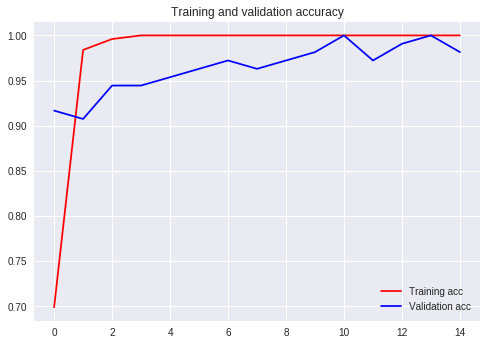

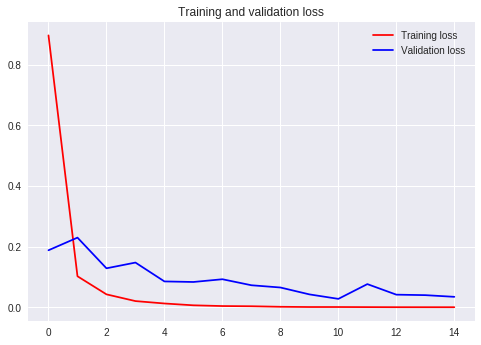

In [0]:
import matplotlib.pyplot as plt

acc = pre_trained.history.history['acc']
val_acc = pre_trained.history.history['val_acc']
loss = pre_trained.history.history['loss']
val_loss = pre_trained.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###6.4 Predicting the test data

Found 154 images belonging to 5 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 1 1 1 3 1 1 1 3 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 4 3 3 3 3 3 3 3 3 3 3 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4]
Confusion matrix, without normalization
[[36  0  1  0  0]
 [ 0 24  0  5  0]
 [ 0  0 29  0  0]
 [ 0  0  0 28  2]
 [ 0  0  0  0 29]]


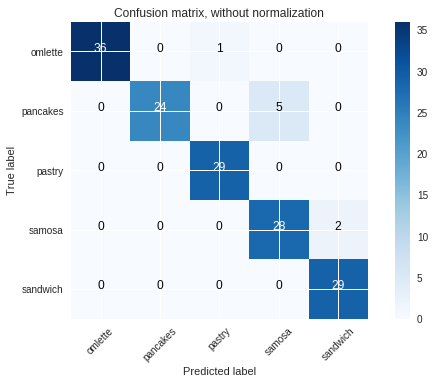

In [0]:
#confusion matrix

classes=['omlette','pancakes','pastry','samosa','sandwich']
test_generator = data_generator.flow_from_directory(test_folder, target_size=(image_size, image_size), batch_size=24,classes=['omlette','pancakes','pastry','samosa','sandwich']   , class_mode='categorical', shuffle=False)
labels_test=test_generator.classes
predictions2= pre_trained.predict_generator(test_generator,steps=7,verbose=0)
print(predictions2.argmax(axis=1))
cm2=confusion_matrix(labels_test,predictions2.argmax(axis=1))

# Compute confusion matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm2, classes,title='Confusion matrix, without normalization')

plt.show()



### 6.5 Results from VGG16

The pre-trained model performed extremely well on the food dataset. The validation accuracy turned out to be 98% which is extremely good.

Except for 'Samosa' class, all the other classes's true labels match the predicted labels.

After the first epoch itself the model hiked to the accracy in the range of 90s. 

Inorder to make the accuracy more than **98**% these are the few more approaches than can be tried.
more aggresive data augmentation


more aggressive dropout

use of L1 and L2 regularization fine-tuning one more convolutional block.


## 7. Conclusion:

Comparing Accuracies of the models.

**Model 1 :** baseline model
Validation accuracy 18-19% for 20 epochs


**Model 2: ** Deeper convolutional network with max pooling layers.

Validation accuracy  approximately 22-23% for 30 epochs


**Model 3**: Deeper convolutional network with data augmentation and drop out layers

Validation accuracy: 44-45 % for 30 epochs
Test Accuracy: 33-35% for 15 epochs

**Model 4**: chnaged hyper parameters for  Deeper convolutional network with data augmentation and drop out layers 

Validation Accuracy : 33-34 % for 30 epochs

**Model 5:**  Fine tuned pretrained netwrok ;VGG16

Validation and test accuracy nearly nearly 97-98% for 15 epochs.
